# Logical Error Rate Evaluation (rotated surface code)

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
decoder = "mwpm"
json_filename = "mwpm.json"  # where to save the result, must be provided

slurm_maximum_jobs = 100
local_maximum_jobs = 10

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor
from qec_lego_bench.hpc.submitter.min_shots_submitter import MinShotsSubmitter
from qec_lego_bench.hpc.submitter.precision_submitter import PrecisionSubmitter
from qec_lego_bench.hpc.plotter.job_progress_plotter import JobProgressPlotter
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import LogicalErrorRatePlotter
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [4]:
d_vec = [3, 5, 7, 9, 11]
p_vec = [0.03 * 0.1 ** (i / 8) for i in range(1, 24)]

# d_vec = [3]
# p_vec = [0.01, 0.03]

jobs = [MonteCarloJob(d=d, p=p) for d in d_vec for p in p_vec]


def monte_carlo_function(shots: int, d: int, p: float) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder=decoder, code=f"rsc(d={d},p={p})", max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

monte_carlo_function(1000, min(d_vec), max(p_vec))

(1000, LogicalErrorResult(errors=199, discards=0))

### Define the strategy to submit jobs

In [5]:
min_shots_submitter = MinShotsSubmitter(shots=10000)
precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=1)
more_precision_submitter = PrecisionSubmitter(time_limit=50*3600, min_precision=2)
def submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    if len(submit) == 0 and all([job.pending_shots == 0 for job in jobs]):  # previous submitter all finished
        submit += more_precision_submitter(jobs)
    return submit

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

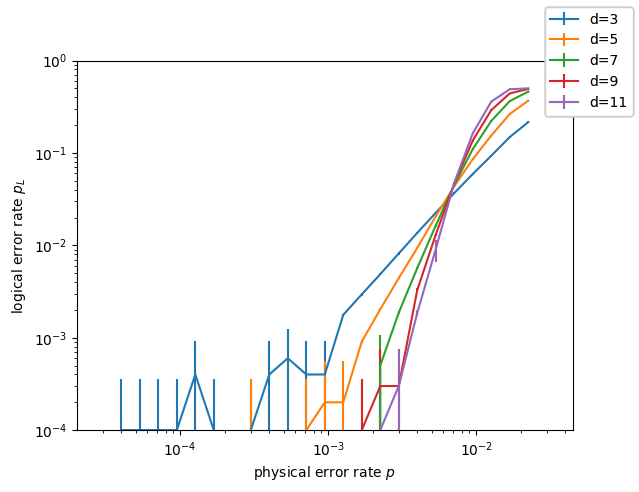

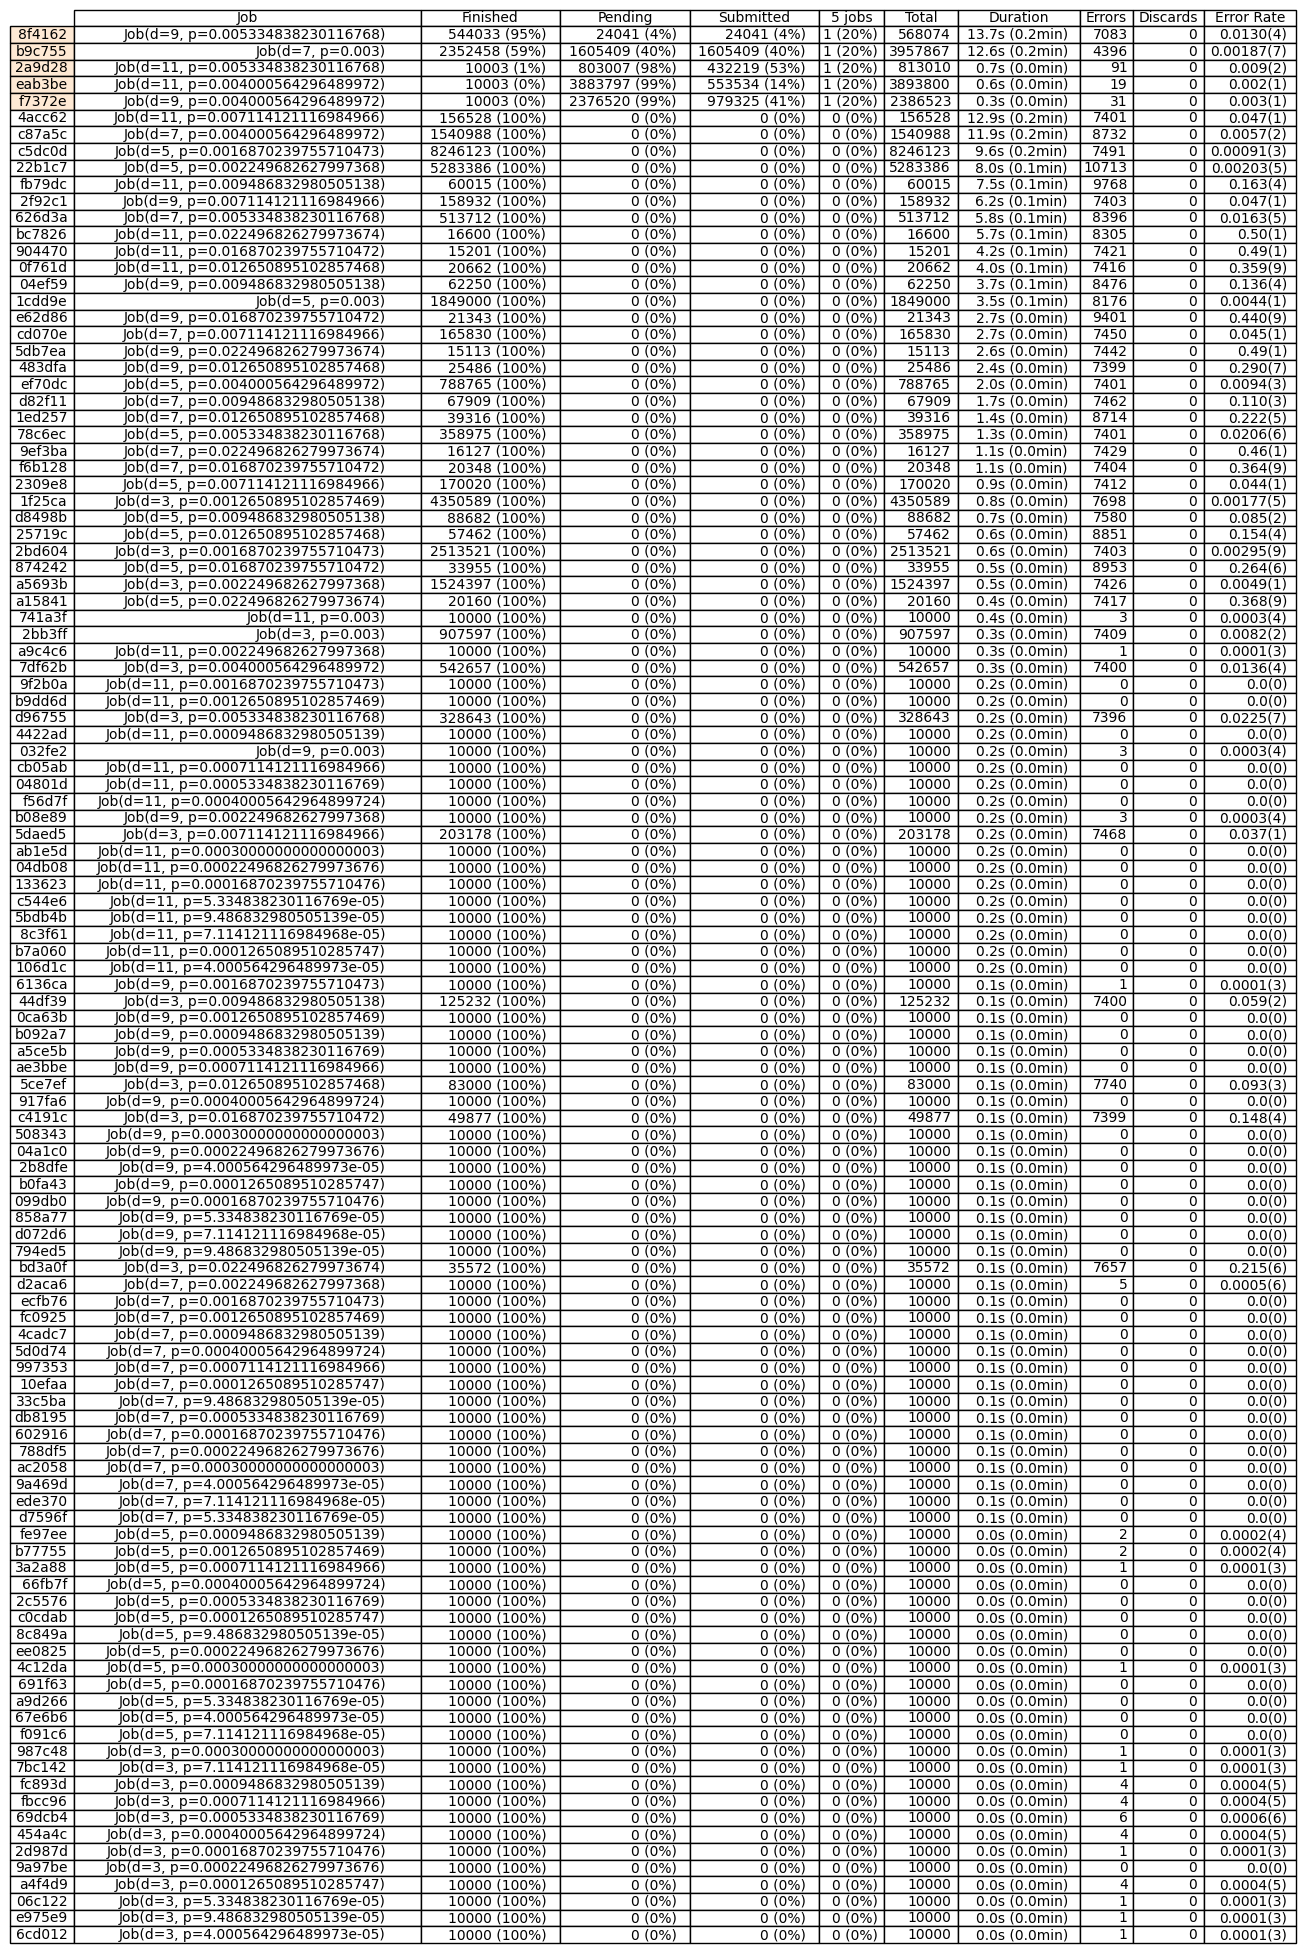

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
plotter = LogicalErrorRatePlotter(d_vec, p_vec)
progress_plotter = JobProgressPlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)

## The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [7]:
try:
    from dask_jobqueue import SLURMCluster
    from dask.distributed import Client
    cores_per_node = 10
    n_workers = slurm_maximum_jobs // cores_per_node
    assert n_workers < 200, "Yale HPC forbids submitting more than 200 jobs per hour"
    cluster = SLURMCluster(
        queue='scavenge',
        cores=cores_per_node,
        processes=cores_per_node,
        memory=f"{4 * cores_per_node} GB",
        walltime="6:00:00",  # 6 hours
    )
    print(cluster.job_script())
    cluster.scale(slurm_maximum_jobs)
except Exception as e:
    print(e)
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(n_workers=local_maximum_jobs)

No module named 'dask_jobqueue'


2025-01-31 22:36:26,558 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:49318' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'monitored_job-4c39c6c943e772f57a2df978a530ecd6'} (stimulus_id='handle-worker-cleanup-1738380986.558609')
2025-01-31 22:36:26,565 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:49326' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'monitored_job-70847bf7e433bbc3b8105f9de2de496b'} (stimulus_id='handle-worker-cleanup-1738380986.565038')


In [8]:
print(cluster.dashboard_link)
cluster

http://127.0.0.1:8787/status


LocalCluster(93dcbe7e, 'tcp://127.0.0.1:49294', workers=10, threads=10, memory=32.00 GiB)

In [9]:
shudown_cluster = False

if shudown_cluster:
    print("will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False")
with Client(cluster) as client:
    try:
        executor = MonteCarloJobExecutor(
            client,
            monte_carlo_function,
            jobs,
            filename=json_filename,
        )
        executor.execute(submitter, loop_callback=callback)
    finally:
        if shudown_cluster:
            print("shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False")
            client.shutdown()

2025-01-31 22:36:26,572 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('monitored_job-6eefef562beee9ceba2a393bdef4791e')" coro=<Worker.execute() done, defined at /opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/distributed/worker_state_machine.py:3606>> ended with CancelledError
2025-01-31 22:36:26,587 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('monitored_job-6fead11fc38f00ef4384e112fbebd0a9')" coro=<Worker.execute() done, defined at /opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/distributed/worker_state_machine.py:3606>> ended with CancelledError
2025-01-31 22:36:26,589 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('monitored_job-6e83c46db3622fb7a16b39bf5051fd50')" coro=<Worker.execute() done, defined at /opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/distributed/worker_

KeyboardInterrupt: 